In [41]:
import pandas as pd
import numpy as np
adler_dataset = pd.read_table('w10-data.tbl',delim_whitespace=True, header = None)

## 1. Write a function that simulates positive control data

In [611]:
import random
def simulate(N, M, R):
    """input
            N: number of genes
            M: number of experiments
            R: number of modules
        output
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
    """
    np.random.seed(1)
    # Initialize W
    battery_assignment = np.random.randint(0,R,N)
    W = np.zeros((N,R))
    for n in range(N):
        mod_idx = battery_assignment[n]
        W[n,mod_idx] = 1

    num_moon_light = np.random.randint(3,7,1)[0]
    print('Randomly Selected {} moon light genes'.format(num_moon_light))
    moon_light_genes = random.sample(range(N),num_moon_light)
    for moon_light in moon_light_genes:
        zero_pos = list(np.where(W[moon_light,] == 0)[0])
        W[moon_light,random.sample(zero_pos,1)] = 1
        
    W = W / W.sum(axis=0)
    # Initialize H
    H = np.random.dirichlet(np.ones(R), size=M).T
    
    # Initialize C
    C = np.random.randint(90000,110000,M) 
    # Calculate lambda
    V_exp = C * np.dot(W,H)
    
    # Calculate simulated V
    V_obs = np.random.poisson(lam=V_exp) 
    
    return V_obs, V_exp, W, H


### Simulating count matrix V_obs with 100 genes , 60 samples, and 3 modules:

In [560]:
V_obs, V_exp, W_sim,H_sim = simulate(N = 100, M = 60, R = 3)

Randomly Selected 3 moon light genes


Text(0.5, 1.0, 'Heatmap of Simulated W Matrix')

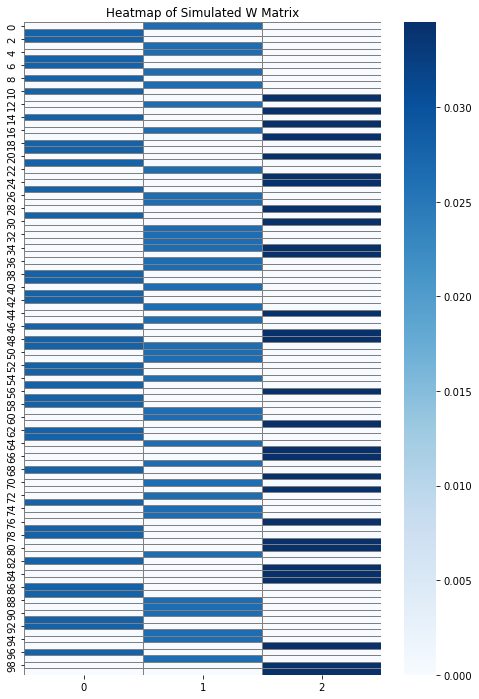

In [565]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(ncols = 1, figsize = (8,12))
sns.heatmap(W_sim,ax = ax,
cmap = "Blues",
linecolor = 'grey',
linewidth = 0.5)
ax.set_title('Heatmap of Simulated W Matrix')

### From the heatmap of the probability matrix W of the gene assignments above. We observe that the generated battery assignments are reasonable. Most of the genes only belong to one battery. There are only three moonlighting genes (gene assigned to two batteries)

## 2. implement nonnegative matrix factorization

In [693]:
def calculate_C(V_obs):
    """input
            V_obs: observed counts matrix (NxM)
        output
            C: total number of counts per experiment (Rx1)
    """
    # Calculate C by summing over the columns of V_obs
    C = V_obs.sum(axis=0)
    
    return C

def calculate_lambda(C, W, H):
    """input
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            V_exp: expected counts matrix (NxM)
    """
    # Calculate expected counts V_exp from C, W, and H
    V_exp =  C * np.dot(W,H)
    
    return V_exp

def update(V_obs, V_exp, C, W, H):
    """input
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            W: updated weights matrix (NxR)
            H: updated mixture coefficients matrix (RxM)
    """

    N = V_obs.shape[0]
    M = V_obs.shape[1]
    R = H.shape[0]
    # Update W
    
    W_new = W*(((V_obs/V_exp)*C)@H.T)
    # Renormalize W
    W_new = W_new / W_new.sum(axis=0)
    
    # Update H
    H_new = H * (W.T@(V_obs/V_exp))




    return W_new, H_new


def log_likelihood(V_obs, V_exp):
    #Calculate loglikelihood using observed counts and expected counts
    ll = (V_obs * np.log(V_exp) - V_exp).sum()
    
    return ll

def NMF(V_obs, R,seed):
    """input
            V_obs: observed counts matrix (NxM)
            R: number of populations
        output
            W: updated weights matrix (NxR)
            H: updated mixture coefficients matrix (RxM)
    """
    # Initialize W and H to random guesses
    np.random.seed(seed)
    W = np.random.dirichlet(np.ones(V_obs.shape[0]), size=R).T
    
    # Initialize H
    H = np.random.dirichlet(np.ones(R), size=V_obs.shape[1]).T
    
    # Calculate lambda
    C = calculate_C(V_obs)
    V_exp = calculate_lambda(C, W, H)
    
    # Check for convergence
    prev_ll = 0
    ll = 10000000
    while (ll - prev_ll > 0.01):

        # Update W and H
        W_new, H_new = update(V_obs, V_exp, C, W, H)
        W = W_new
        H = H_new
        
        # Calculate lambda
        V_exp = calculate_lambda(C, W, H)

        # Calculate the log likelihood
        prev_ll = ll
        ll = log_likelihood(V_obs, V_exp)
    
    return W, H, ll

### My NMF implementation follows the following steps:
### Given the input R and N and M inferred from the observed V matrix the function first initializes a W and H matrix where $∑_i W_{ia}=1.$ and $∑_a H_{au} = 1$. C is calculated from the observed V matrix and then $\lambda$ is then calculated given C, W, and H.  Then algorithm then enters into a while loop which does the optmization:
## While  log likelihood - previous log likelihood is greater than 0.01:
### 1. Update W and H using the derived update equations for $W′_{ia}$, $W′′_{ia}$, and $H′_{aμ}$.
### 2. Recalculate $\lambda$ using $\lambda = WH$
### 3. Calculate log likelihood


## 3. Test your implementation

### Running the NMF algorithm with 50 different sets of intialized W and H based on 50 different seeds set of simulated V with number of modules R = 3

In [576]:
list_of_W = []
list_of_H = []
list_of_ll = []
seeds = np.random.randint(0,1000,50)

for seed in seeds:
    W,H, LL = NMF(V_obs, R=3, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)
best_run = np.argmax(list_of_ll)
H = list_of_H[best_run]
W = list_of_W[best_run]

Text(0.5, 1.0, 'Optimized W (R=3,N=100,M=60)')

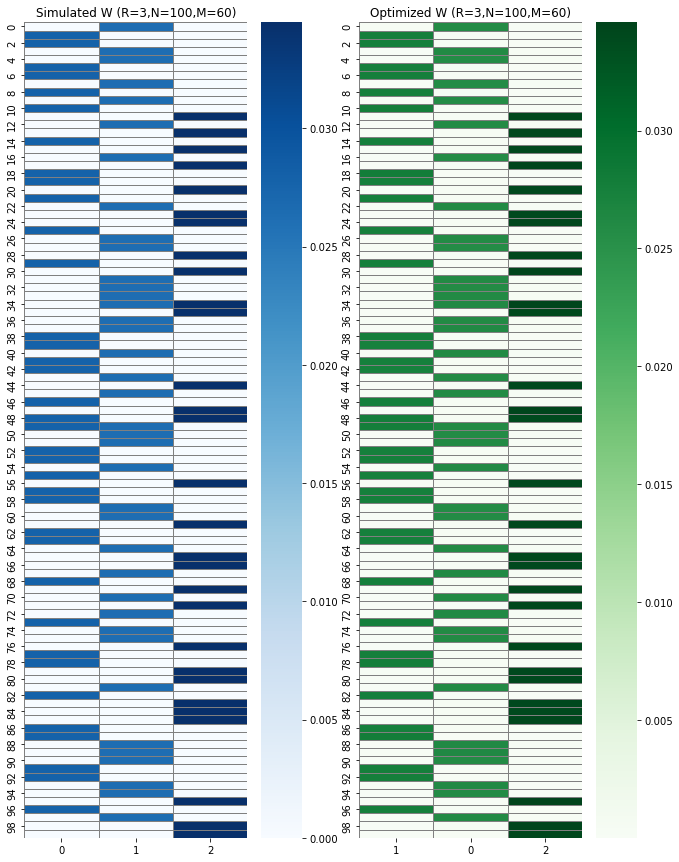

In [613]:
fig,ax = plt.subplots(ncols = 2, figsize = (11,15))
sns.heatmap(W_sim,ax = ax[0],
cmap = "Blues",
linecolor = 'grey',
linewidth = 0.5)
ax[0].set_title('Simulated W (R=3,N=100,M=60)')

sns.heatmap(pd.DataFrame(W).iloc[:,[1,0,2]],ax = ax[1],
cmap = "Greens",
linecolor = 'grey',
linewidth = 0.5)
ax[1].set_title('Optimized W (R=3,N=100,M=60)')

### Running the NMF algorithm with 50 different sets of intialized W and H with new set of simulated V with number of modules R = 5, N = 80, and M = 50

In [612]:
V_obs_5, V_exp_5, W_sim_5,H_sim_5 = simulate(N = 80, M = 50, R = 5)

list_of_W_5 = []
list_of_H_5 = []
list_of_ll_5 = []

seeds = np.random.randint(0,1000,50)

for seed in seeds:
    W_5,H_5, LL_5 = NMF(V_obs_5, R=5, seed=seed)
    list_of_W_5.append(W_5)
    list_of_H_5.append(H_5)
    list_of_ll_5.append(LL_5)
best_run_5 = np.argmax(list_of_ll_5)
H_5 = list_of_H_5[best_run_5]
W_5 = list_of_W_5[best_run_5]

Randomly Selected 4 moon light genes


Text(0.5, 1.0, 'Optimized W (R=5,N=80,M=50)')

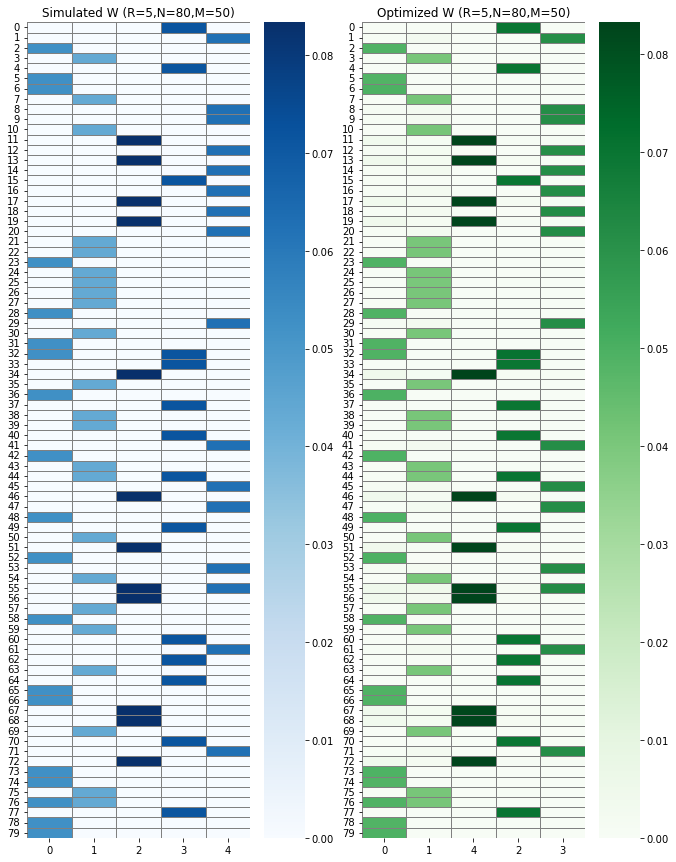

In [618]:
fig,ax = plt.subplots(ncols = 2, figsize = (11,15))
sns.heatmap(W_sim_5,ax = ax[0],
cmap = "Blues",
linecolor = 'grey',
linewidth = 0.5)
ax[0].set_title('Simulated W (R=5,N=80,M=50)')

sns.heatmap(pd.DataFrame(W_5).iloc[:,[0,1,4,2,3]],ax = ax[1],
cmap = "Greens",
linecolor = 'grey',
linewidth = 0.5)
ax[1].set_title('Optimized W (R=5,N=80,M=50)')

### Looking at the ground truth simulated W and the W generated from NMF, we observe that they are pretty much identical. Thus, NMF does a good job reconstructing known gene batteries.

## 4. analyze the Adler data

### I am going to test out R = 3-6 with 20 different initializations each.

In [640]:
list_of_W = []
list_of_H = []
list_of_ll = []

seeds = np.random.randint(0,1000,20)

for seed in seeds:
    W,H, LL = NMF(adler_dataset.iloc[:,1:].to_numpy(), R=3, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)

for seed in seeds:
    W,H, LL = NMF(adler_dataset.iloc[:,1:].to_numpy(), R=4, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)

for seed in seeds:
    W,H, LL = NMF(adler_dataset.iloc[:,1:].to_numpy(), R=5, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)

for seed in seeds:
    W,H, LL = NMF(adler_dataset.iloc[:,1:].to_numpy(), R=6, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)

best_run = np.argmax(list_of_ll)
H = list_of_H[best_run]
W = list_of_W[best_run]
del list_of_H, list_of_W

Text(0, 0.5, 'Log Likelihood (1e-7)')

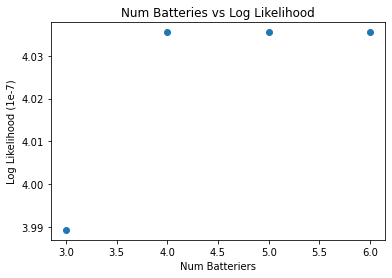

In [656]:
lls = np.array(np.array(list_of_ll)/10**7).reshape(4,20)
plt.scatter([3,4,5,6],lls.mean(axis=1))
plt.title('Num Batteries vs Log Likelihood')
plt.xlabel('Num Batteriers')
plt.ylabel('Log Likelihood (1e-7)')

### My guess is there are 4 batteries. Because the log likelihood stops increasing once the number of batteries hits 4.

In [681]:
list_of_W = []
list_of_H = []
list_of_ll = []
for seed in seeds:
    W,H, LL = NMF(adler_dataset.iloc[:,1:].to_numpy(), R=4, seed=seed)
    list_of_W.append(W)
    list_of_H.append(H)
    list_of_ll.append(LL)
best_run = np.argmax(list_of_ll)
H = list_of_H[best_run]
W = list_of_W[best_run]

### Number of genes in each battery:

In [682]:
print('Battery 1')
print(sum(W.argmax(axis=1)==0))
print('Battery 2')
print(sum(W.argmax(axis=1)==1))
print('Battery 3')
print(sum(W.argmax(axis=1)==2))
print('Battery 4')
print(sum(W.argmax(axis=1)==3))

Battery 1
18
Battery 2
43
Battery 3
20
Battery 4
19


### There are 18 genes in battery 1, 43 genes in battery 2, 20 genes in battery 3,and 19 genes in battery 4.

[Text(87.0, 0.5, 'Genes')]

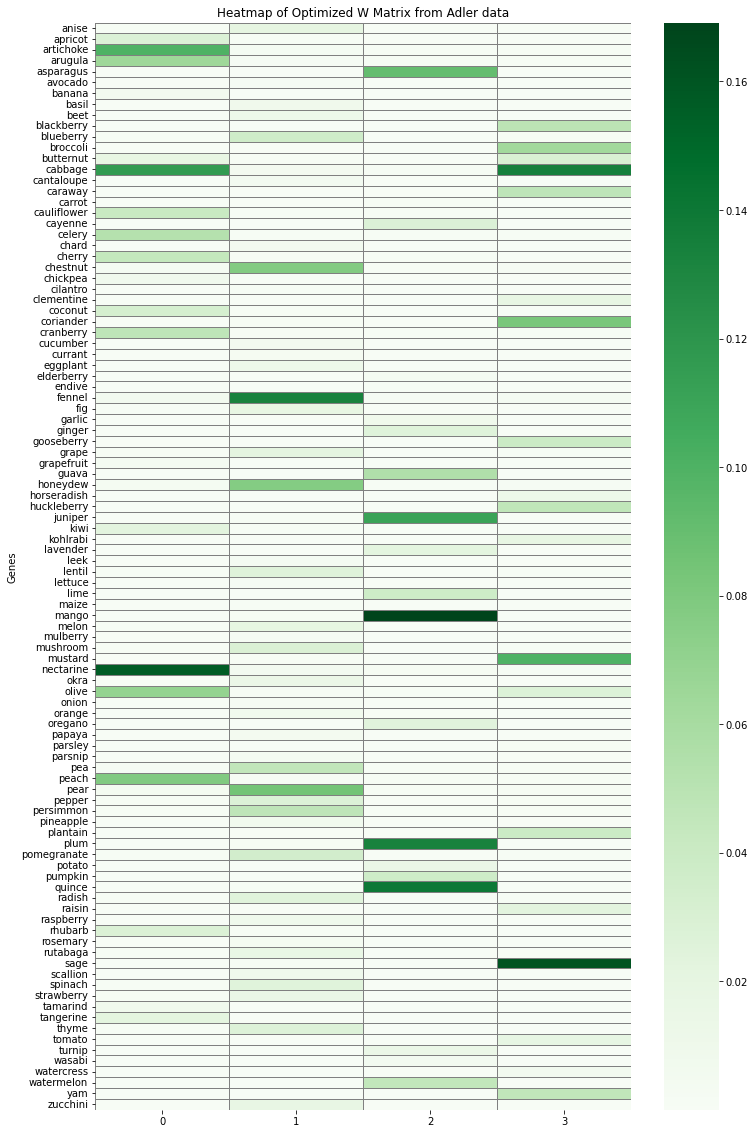

In [692]:
fig,ax = plt.subplots(ncols = 1, figsize = (12,20))
g = sns.heatmap(pd.DataFrame(W,index=adler_dataset.iloc[:,0]),ax = ax,
cmap = "Greens",
linecolor = 'grey',
linewidth = 0.5)
ax.set_title('Heatmap of Optimized W Matrix from Adler data')
g.set(ylabel='Genes')

### I can see three moonlighting genes, they are butternut, cabbage, and olive.